# Add Topic Classification to Twitter Data
create classifier model to predict topic of tweet using LDA and apply model to corpus of tweets

# NLP and LDA modeling

In [148]:
import re
import gensim
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import pyLDAvis.gensim
import random
from gensim.test.utils import datapath
import pickle

# set all the seeds
np.random.seed(seed=42)
random.seed(42)

In [2]:
# Read yelp.csv into a DataFrame.
path = r'C:/Users/598300/GA-DS/dcmwwave4/Final-Project/juul.csv'  
#It is helpful in writing in special characters.
tweets = pd.read_csv(path)
tweets.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,id,date_scraped,tweet_date,tweet_datetime,tweet_hour,tweet_time,tweet_day_of_week,text,lang,...,favorite_count,longitude,latitude,unique_tweet_id,short_tweet_id,recent_stat_summary,find_most_recent,most_recent_id,retweet_indicator,favorite_indicator
0,1,1.058540e+18,20181106,11/3/2018,11/3/2018 2:15,2,nighttime,Saturday,Mango Twist 55mg 🔥🔥🔥 #saltnic #saltnicotine #...,tl,...,1.0,NaN,NaN,2.0,27179.0,2210.0,2.018110e+11,2.018110e+11,0.0,1.0
1,169,1.057350e+18,20181106,10/30/2018,10/30/2018 19:29,19,nighttime,Tuesday,Strawberry Lemonade 🍓🍋 15ml bottles now availa...,en,...,1.0,NaN,NaN,169.0,20375.0,2210.0,2.018110e+11,2.018110e+11,0.0,1.0
2,184,1.057050e+18,20181106,10/29/2018,10/29/2018 23:39,23,nighttime,Monday,55mg Blue Rasberry Pod Juice. Fill up your Suo...,en,...,0.0,NaN,NaN,184.0,18789.0,2209.0,2.018110e+11,2.018110e+11,0.0,0.0
3,185,1.057050e+18,20181106,10/29/2018,10/29/2018 23:10,23,nighttime,Monday,"Juuling may be trendy, but that doesn’t mean i...",en,...,0.0,NaN,NaN,185.0,18735.0,63.0,2.018111e+09,2.018111e+09,0.0,0.0
4,187,1.057040e+18,20181106,10/29/2018,10/29/2018 23:00,23,nighttime,Monday,"""It's a wonderful, wonderful alternative to sm...",en,...,8.0,NaN,NaN,187.0,18715.0,27658.0,2.018110e+12,2.018110e+12,1.0,1.0


In [3]:
tweets.columns

Index(['Unnamed: 0', 'id', 'date_scraped', 'tweet_date', 'tweet_datetime',
       'tweet_hour', 'tweet_time', 'tweet_day_of_week', 'text', 'lang',
       'screen_name', 'location', 'protected', 'profile_description',
       'followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'geo_enabled', 'verified', 'statuses_count', 'retweet_count',
       'favorite_count', 'longitude', 'latitude', 'unique_tweet_id',
       'short_tweet_id', 'recent_stat_summary', 'find_most_recent',
       'most_recent_id', 'retweet_indicator', 'favorite_indicator'],
      dtype='object')

In [4]:
tweets.drop(['Unnamed: 0', 'id','date_scraped','tweet_datetime',\
             'lang','screen_name','longitude','latitude','protected',\
             'unique_tweet_id', 'short_tweet_id','recent_stat_summary', \
             'find_most_recent', 'most_recent_id'], axis = 1, inplace = True)

In [5]:
# The head of the original data
tweets.shape

(39461, 18)

Start with actual tweet content

In [7]:
# isolate text column
text_df = tweets.text

In [8]:
text_df.head()

0    Mango Twist 55mg 🔥🔥🔥 #saltnic  #saltnicotine #...
1    Strawberry Lemonade 🍓🍋 15ml bottles now availa...
2    55mg Blue Rasberry Pod Juice. Fill up your Suo...
3    Juuling may be trendy, but that doesn’t mean i...
4    "It's a wonderful, wonderful alternative to sm...
Name: text, dtype: object

In [9]:
text_df.tail()

39456           Pisses me off they’re banning juul pods 🙄🙄
39457    So I bought a Juul to help me quit smoking. I ...
39458    ZiiP PODS FOR JUUL DEVICES - MINT 5% \r\n$9.99...
39459    In need of juul pods but don’t wanna leave the...
39460    When are they gonna legalize weed on @TheSims?...
Name: text, dtype: object

Preprocess text and fit LDA - borrowed heavily from the following sources:
 - https://www.programcreek.com/python/example/94106/nltk.tokenize.TweetTokenizer
 - https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html
 - https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [10]:
# recreate stopword list to exclude punctuation bc that will be how tweet 
# words are fed into the workflow
stopword_list = [re.sub(r'[^\w@#\s]', '', w) for w in \
                 stopwords.words('english')]
# addition to stopword list
stopword_list += ['amp','lampm','im','ive','u','ur','cant','could','would'] # amp and lampm weird mapping from character(&)
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', '

In [198]:
# preprocess tweets
def tweet_preprocess(text, stopword_list):
    # split contractions
    p_text = re.sub(r'\'',' ', text)
    
    #remove hyperlinks
    p_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', p_text)
    
    # remove symbols excluding the @, # symbols
    p_text = re.sub(r'[^\w@#\s]', '', p_text)
    
    # use tweet tokenizer from NLTK package to split words
    tknzr = TweetTokenizer()
    p_text = tknzr.tokenize(p_text)
    
    # remove stopwords, strip whitespace and lower everything
    p_text = [w.strip().lower() for w in p_text if w.strip().lower() not in stopword_list and not w.isdigit()]

    # keep track of ids with empty strings
#     if len(p_text) == 0:
#         p_text = ['EMPTY']
        
    return p_text

In [55]:
# from nltk.corpus import wordnet as wn
# def get_lemma(word):
#     lemma = wn.morphy(word)
#     if lemma is None:
#         return word
#     else:
#         return lemma
    
# from nltk.stem.wordnet import WordNetLemmatizer
# def get_lemma2(word):
#     return WordNetLemmatizer().lemmatize(word)

In [203]:
# execute preprocesing 
def preprocess_and_create_dict(text_df, stopword_list, min_doc_freq):
    
    # use function to preprocess tweet text into list of words
    preprocessed_tweets_w_dupes = [tweet_preprocess(tweet_text, stopword_list) for\
                       tweet_text in list(text_df)]
    print(len(preprocessed_tweets_w_dupes))
    
    # remove duplicate content - happens when different users share the same headline, etc
    # don't want the topic model inflated with this content
    preprocessed_tweets = [list(x) for x in set(tuple(x) for x in preprocessed_tweets_w_dupes)]
    print(len(preprocessed_tweets))
    
    ## create a index of words in tweets using gensim's function Dictionary
    dictionary = Dictionary(preprocessed_tweets)
    print(len(dictionary))
    
    ## only do this for initial fit
    dictionary.filter_extremes(no_below = min_doc_freq)
    print(len(dictionary))

    # convert to bag of words
    corpus = [dictionary.doc2bow(text) for text in preprocessed_tweets] 
    
    return preprocessed_tweets_w_dupes, preprocessed_tweets, dictionary, corpus


In [13]:
def fit_lda_cv_coherence(corpus, dictionary, text_df, limit):
    c_v = []
    lda_list = []
    for n_topics in range(2, limit):
        lda_model = LdaModel(corpus = corpus, num_topics = n_topics,\
                             id2word = dictionary, random_state = 42)
        lda_list.append(lda_model)
        cm = CoherenceModel(model = lda_model, texts= text_df, \
                            dictionary = dictionary, coherence = 'c_v')
        c_v.append(cm.get_coherence())
    
    x = range(2,limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

    return lda_list, c_v

In [200]:
def format_topics_tweets(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # create dataframe with keywords for each topic
    keyword_dict = dict()
    for topic_nb, list_words in ldamodel.show_topics(formatted = False):
        keyword_string = str()
        for x in list_words:
            keyword_string += ' ' + x[0]
        print('topic', topic_nb,'words:', keyword_string)
        keyword_dict[topic_nb] = keyword_string

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic per each row which has been ordered by proportion
                topic_keywords = keyword_dict[topic_num]
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), \
                                    round(prop_topic,4), topic_keywords]), ignore_index=True) 
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    return(sent_topics_df)


In [201]:
def pull_most_representative_tweets(topic_model, corpus, preprocessed_tweets, n):
    # make df of top tweets
    df_tweet_topics = format_topics_tweets(ldamodel=topic_model, corpus=corpus, texts=preprocessed_tweets)

    # pull top n tweets for each topic
    top_tweets = pd.DataFrame()
    group_by_topic_df = df_tweet_topics.groupby('Dominant_Topic')
    for i, grp in group_by_topic_df:
        top_tweets = pd.concat([top_tweets, grp.sort_values(['Topic_Perc_Contrib'], 
                                                            ascending=[0]).head(n)], 
                                                axis=0)

    # Reset Index    
    top_tweets.reset_index(drop=True, inplace=True)
    
    return df_tweet_topics, top_tweets

In [204]:
# preprocess and tokenize tweet text
preprocessed_tweets_w_dupes, preprocessed_tweets, dictionary, corpus = preprocess_and_create_dict(text_df,\
                                                                        stopword_list, 2)

39461
35775
28336
10280


28336
10280


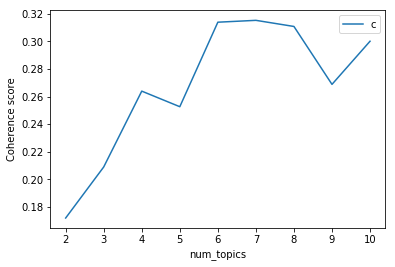

Wall time: 3min 32s


In [69]:
%%time
#### main function ####

# find best fit lda model
lda_list, c_v = fit_lda_cv_coherence(corpus, dictionary, \
                               preprocessed_tweets, 11)

In [70]:
list(zip(list(range(2,12)), c_v)) # five topics is optimal based on coherence

[(2, 0.17208189314176692),
 (3, 0.20902609294480945),
 (4, 0.2639108730385691),
 (5, 0.25263519582674204),
 (6, 0.31380039644115626),
 (7, 0.3151477997235144),
 (8, 0.3107147259894976),
 (9, 0.26880789828225676),
 (10, 0.3000269548652814)]

In [71]:
topic_model = lda_list[7-2]

In [73]:
# Print the Keyword in the 10 topics
pprint(topic_model.print_topics())

[(0,
  '0.037*"hit" + 0.015*"bro" + 0.013*"let" + 0.010*"like" + 0.009*"said" + '
  '0.009*"pod" + 0.008*"please" + 0.008*"pods" + 0.008*"cool" + 0.008*"one"'),
 (1,
  '0.025*"stop" + 0.023*"flavors" + 0.023*"flavored" + 0.018*"stores" + '
  '0.017*"ecigarette" + 0.017*"fda" + 0.014*"vaping" + 0.014*"nicotine" + '
  '0.014*"selling" + 0.013*"sales"'),
 (2,
  '0.020*"time" + 0.018*"every" + 0.014*"last" + 0.013*"mom" + 0.013*"hit" + '
  '0.012*"juuling" + 0.012*"rip" + 0.011*"night" + 0.010*"hitting" + '
  '0.009*"lost"'),
 (3,
  '0.118*"pods" + 0.038*"mango" + 0.018*"buy" + 0.015*"got" + 0.014*"pod" + '
  '0.014*"banned" + 0.012*"like" + 0.012*"get" + 0.012*"flavored" + '
  '0.009*"mint"'),
 (4,
  '0.026*"lost" + 0.017*"one" + 0.014*"juuls" + 0.012*"ever" + 0.011*"lose" + '
  '0.010*"hit" + 0.010*"found" + 0.010*"day" + 0.008*"new" + 0.008*"thing"'),
 (5,
  '0.024*"say" + 0.017*"hit" + 0.013*"wanna" + 0.012*"pods" + 0.010*"make" + '
  '0.010*"smoke" + 0.009*"juuling" + 0.009*"need" + 0

In [111]:
pyLDAvis.enable_notebook()

In [21]:
vis_data = pyLDAvis.gensim.prepare(topic_model, corpus, dictionary, sort_topics=False)
# note that each topic above is n + 1 in the plot below
# choose 0, 1, 3, 6 so 1,2,4,7
pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, 'pylda_vis.html')

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [146]:
%%time
df_tweet_topics, top_tweets = pull_most_representative_tweets(topic_model, corpus, preprocessed_tweets, 500)

topic 0 words:  hit bro let like said pod please pods cool one
topic 1 words:  stop flavors flavored stores ecigarette fda vaping nicotine selling sales
topic 2 words:  time every last mom hit juuling rip night hitting lost
topic 3 words:  pods mango buy got pod banned like get flavored mint
topic 4 words:  lost one juuls ever lose hit found day new thing
topic 5 words:  say hit wanna pods make smoke juuling need like kids
topic 6 words:  like pod get smoking cigarettes people charger nicotine pods quit
Wall time: 2min 9s


In [147]:
top_tweets.columns

Index(['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text'], dtype='object')

In [150]:
filter_logic = ((top_tweets['Dominant_Topic'] == 0) | (top_tweets['Dominant_Topic'] == 1) | \
                (top_tweets['Dominant_Topic'] == 3) | (top_tweets['Dominant_Topic'] == 6))
top_tweets = top_tweets[filter_logic]
top_tweets['text_string'] = [' '.join(x) for x in top_tweets['Text']]

# short description of topic
top_tweets['topic_string'] = np.where(top_tweets['Dominant_Topic'] == 0,'juul usage', top_tweets['Dominant_Topic'])
top_tweets['topic_string'] = np.where(top_tweets['Dominant_Topic'] == 1,'news headlines', top_tweets['topic_string'])
top_tweets['topic_string'] = np.where(top_tweets['Dominant_Topic'] == 3,'juulpods and flavors', top_tweets['topic_string'])
top_tweets['topic_string'] = np.where(top_tweets['Dominant_Topic'] == 6,'nicotine and comparison to cigarettes', top_tweets['topic_string'])

# convert to sequential topics
top_tweets['topic_numeric'] = np.where(top_tweets['Dominant_Topic'] == 0, 1, top_tweets['Dominant_Topic'])
top_tweets['topic_numeric'] = np.where(top_tweets['Dominant_Topic'] == 1, 2, top_tweets['topic_numeric'])
top_tweets['topic_numeric'] = np.where(top_tweets['Dominant_Topic'] == 3, 3, top_tweets['topic_numeric'])
top_tweets['topic_numeric'] = np.where(top_tweets['Dominant_Topic'] == 6, 4, top_tweets['topic_numeric'])

In [151]:
top_tweets.head()

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,text_string,topic_string,topic_numeric
0,0.0,0.9523,hit bro let like said pod please pods cool one,"[yo, bro, got, juul, bro, cmon, bro, real, qui...",yo bro got juul bro cmon bro real quick restro...,juul usage,1.0
1,0.0,0.9522,hit bro let like said pod please pods cool one,"[@whouphitlike, bro, pls, lemme, hit, juul, pl...",@whouphitlike bro pls lemme hit juul pls need ...,juul usage,1.0
2,0.0,0.9428,hit bro let like said pod please pods cool one,"[@leopinkyoshi, bro, take, hit, juul, bro, bro...",@leopinkyoshi bro take hit juul bro bro please...,juul usage,1.0
3,0.0,0.9284,hit bro let like said pod please pods cool one,"[parents, fucking, champions, threw, entire, t...",parents fucking champions threw entire temper ...,juul usage,1.0
4,0.0,0.9283,hit bro let like said pod please pods cool one,"[mom, took, juul, rn, said, thank, _, _, next,...",mom took juul rn said thank _ _ next gt _ _,juul usage,1.0


In [152]:
top_tweets.to_csv('juul_topic_classification_filtered.csv')

In [18]:
filename = 'juul_lda_topic_model.pickle'
#pickle.dump(topic_model, open(filename,'wb'))

In [19]:
topic_model = pickle.load(open(filename, 'rb'))

In [20]:
topic_model.show_topics()

[(0,
  '0.037*"hit" + 0.015*"bro" + 0.013*"let" + 0.010*"like" + 0.009*"said" + 0.009*"pod" + 0.008*"please" + 0.008*"pods" + 0.008*"cool" + 0.008*"one"'),
 (1,
  '0.025*"stop" + 0.023*"flavors" + 0.023*"flavored" + 0.018*"stores" + 0.017*"ecigarette" + 0.017*"fda" + 0.014*"vaping" + 0.014*"nicotine" + 0.014*"selling" + 0.013*"sales"'),
 (2,
  '0.020*"time" + 0.018*"every" + 0.014*"last" + 0.013*"mom" + 0.013*"hit" + 0.012*"juuling" + 0.012*"rip" + 0.011*"night" + 0.010*"hitting" + 0.009*"lost"'),
 (3,
  '0.118*"pods" + 0.038*"mango" + 0.018*"buy" + 0.015*"got" + 0.014*"pod" + 0.014*"banned" + 0.012*"like" + 0.012*"get" + 0.012*"flavored" + 0.009*"mint"'),
 (4,
  '0.026*"lost" + 0.017*"one" + 0.014*"juuls" + 0.012*"ever" + 0.011*"lose" + 0.010*"hit" + 0.010*"found" + 0.010*"day" + 0.008*"new" + 0.008*"thing"'),
 (5,
  '0.024*"say" + 0.017*"hit" + 0.013*"wanna" + 0.012*"pods" + 0.010*"make" + 0.010*"smoke" + 0.009*"juuling" + 0.009*"need" + 0.009*"like" + 0.009*"kids"'),
 (6,
  '0.023*"

## Use the Labeled Topic Dataset to Create Model to Predict Topic

In [35]:
top_tweets = pd.read_csv('juul_topic_classification_filtered.csv', usecols=['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text_string', 'topic_string', 'topic_numeric'])

In [36]:
top_tweets.columns

Index(['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text_string',
       'topic_string', 'topic_numeric'],
      dtype='object')

In [37]:
top_tweets.head()

,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_string,topic_string,topic_numeric
0,0.0,0.9523,hit bro let like said pod please pods cool one,yo bro got juul bro cmon bro real quick restro...,juul usage,1.0
1,0.0,0.9522,hit bro let like said pod please pods cool one,@whouphitlike bro pls lemme hit juul pls need ...,juul usage,1.0
2,0.0,0.9428,hit bro let like said pod please pods cool one,@leopinkyoshi bro take hit juul bro bro please...,juul usage,1.0
3,0.0,0.9284,hit bro let like said pod please pods cool one,parents fucking champions threw entire temper ...,juul usage,1.0
4,0.0,0.9283,hit bro let like said pod please pods cool one,mom took juul rn said thank _ _ next gt _ _,juul usage,1.0


In [38]:
CountVectorizer() # options

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [130]:
vect = CountVectorizer(analyzer = 'word' \
                       ,tokenizer = None \
                       ,preprocessor = None \
                       ,stop_words = None \
                       ,min_df = 2
                       ,max_features = 800 \
                       # include @ and # within token
                       ,token_pattern = r'(?u)\b\w\w+\b|\#\b\w\w+\b|\@\b\w\w+\b'
                      )

In [131]:
# Use CountVectorizer to create document-term matrices from tweet data
#vect = CountVectorizer() # no specific options
tweet_dtm = vect.fit_transform(top_tweets['text_string'])

In [132]:
tweet_dtm.shape 

(2000, 800)

In [133]:
# Last 50 features
#print(vect.get_feature_names())
words = vect.get_feature_names()

In [134]:
words

['#addiction',
 '#america',
 '#business',
 '#cashmaster',
 '#cybercit2',
 '#ecig',
 '#ecigarette',
 '#ecigarettes',
 '#ecigs',
 '#edchat',
 '#eliquids',
 '#feedly',
 '#findom',
 '#flavors',
 '#foxbusiness',
 '#health',
 '#healthnews',
 '#highered',
 '#juul',
 '#juuling',
 '#juulnation',
 '#juulpods',
 '#juulvapor',
 '#lotusvapeandsmokeshop',
 '#mnleg',
 '#mods',
 '#news',
 '#patent',
 '#pr',
 '#priorities',
 '#redribbonweek2018',
 '#saltbaseliquid',
 '#smoking',
 '#snowwolf',
 '#startup',
 '#startups',
 '#t21mn',
 '#tech',
 '#technology',
 '#teens',
 '#tisonroos',
 '#tobacco',
 '#tobacco21',
 '#vape',
 '#vaping',
 '#whywisd',
 '#wral',
 '18th',
 '@auburnflame220',
 '@barstoolsports',
 '@bbcbusiness',
 '@cbsnews',
 '@cnbc',
 '@fisch_64',
 '@googlenews',
 '@ingrahamangle',
 '@janhoffmannyt',
 '@juulboyz',
 '@juulvapor',
 '@lilmixedhunny',
 '@mailonline',
 '@mertskefan',
 '@miss_wisconsin',
 '@natels_',
 '@nbcnews',
 '@nythealth',
 '@nytimes',
 '@smokefreegenmn',
 '@stephermer',
 '@suckmy

In [135]:
tweet_dtm = tweet_dtm.toarray()

In [136]:
X = tweet_dtm
X

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [137]:
y = top_tweets['topic_numeric']
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: topic_numeric, dtype: float64

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [139]:
LinearSVC()

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [145]:
#instantiate
lsvc = LinearSVC(multi_class = 'crammer_singer', random_state=42, verbose = 1)

#fit
lsvc.fit(X_train, y_train)

#predict
y_pred_svc = lsvc.predict(X_test)

#score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_svc))
print(lsvc.coef_)

[LibLinear]             precision    recall  f1-score   support

        1.0       0.89      0.90      0.90       157
        2.0       0.92      0.98      0.95       145
        3.0       0.90      0.91      0.90       138
        4.0       0.90      0.83      0.87       160

avg / total       0.90      0.90      0.90       600

[[ 0.00000000e+00  0.00000000e+00 -3.46944695e-18 ...  4.82070038e-01
   0.00000000e+00  0.00000000e+00]
 [-8.10983225e-17  0.00000000e+00 -8.67361738e-17 ... -3.46944695e-18
   0.00000000e+00  7.77704584e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.76643000e-01
   0.00000000e+00  0.00000000e+00]
 [-4.33680869e-19  0.00000000e+00  0.00000000e+00 ... -5.42703786e-03
   0.00000000e+00 -7.77704584e-02]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [149]:
MultinomialNB()

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [157]:
# instantiate
nb = MultinomialNB(alpha = .5)

# fit 
nb.fit(X_train, y_train)

# predict
y_pred_nb = nb.predict(X_test)

# score
print(classification_report(y_test, y_pred_nb))

             precision    recall  f1-score   support

        1.0       0.92      0.91      0.91       157
        2.0       0.97      0.94      0.96       145
        3.0       0.91      0.94      0.93       138
        4.0       0.91      0.91      0.91       160

avg / total       0.93      0.93      0.93       600



In [159]:
y_pred_nb[1:10]

array([1., 3., 2., 3., 4., 2., 4., 1., 3.])

In [160]:
y_test[1:10]

353     1.0
1333    3.0
905     2.0
1289    3.0
1273    3.0
938     2.0
1731    4.0
65      1.0
1323    3.0
Name: topic_numeric, dtype: float64

In [213]:
filename = 'juul_naive_bayes_topic_classifier.pickle'
pickle.dump(nb, open(filename,'wb'))

## Use Classification Model to Predict Topic for all Tweets in Corpus

In [185]:
# preprocessed tweets have already gone through the standard function to
# to standardize, remove punctuation, and tweet-tokenize
# here, we remove all words in each tweet which are not used in the 
# classification model above
topic_predictors = vect.get_feature_names()
topic_predictors

['#addiction',
 '#america',
 '#business',
 '#cashmaster',
 '#cybercit2',
 '#ecig',
 '#ecigarette',
 '#ecigarettes',
 '#ecigs',
 '#edchat',
 '#eliquids',
 '#feedly',
 '#findom',
 '#flavors',
 '#foxbusiness',
 '#health',
 '#healthnews',
 '#highered',
 '#juul',
 '#juuling',
 '#juulnation',
 '#juulpods',
 '#juulvapor',
 '#lotusvapeandsmokeshop',
 '#mnleg',
 '#mods',
 '#news',
 '#patent',
 '#pr',
 '#priorities',
 '#redribbonweek2018',
 '#saltbaseliquid',
 '#smoking',
 '#snowwolf',
 '#startup',
 '#startups',
 '#t21mn',
 '#tech',
 '#technology',
 '#teens',
 '#tisonroos',
 '#tobacco',
 '#tobacco21',
 '#vape',
 '#vaping',
 '#whywisd',
 '#wral',
 '18th',
 '@auburnflame220',
 '@barstoolsports',
 '@bbcbusiness',
 '@cbsnews',
 '@cnbc',
 '@fisch_64',
 '@googlenews',
 '@ingrahamangle',
 '@janhoffmannyt',
 '@juulboyz',
 '@juulvapor',
 '@lilmixedhunny',
 '@mailonline',
 '@mertskefan',
 '@miss_wisconsin',
 '@natels_',
 '@nbcnews',
 '@nythealth',
 '@nytimes',
 '@smokefreegenmn',
 '@stephermer',
 '@suckmy

In [205]:
tweet_strings = [' '.join(x) for x in preprocessed_tweets_w_dupes]
len(tweet_strings)

39461

In [206]:
transform_vect = CountVectorizer(analyzer = 'word' \
                       ,tokenizer = None \
                       ,preprocessor = None \
                       ,stop_words = None \
                       # include @ and # within token
                       ,token_pattern = r'(?u)\b\w\w+\b|\#\b\w\w+\b|\@\b\w\w+\b'
                       ,vocabulary = topic_predictors # only allow words which were used to fit initial model
                      )

In [207]:
corpus_dtm = transform_vect.fit_transform(tweet_strings)
X_corpus = corpus_dtm.toarray()

In [208]:
topic_classification_corpus = nb.predict(X_corpus)
len(topic_classification_corpus)

39461

In [212]:
print(tweets.shape)
tweets['tweet_topic'] = topic_classification_corpus

# short description of topic
tweets['tweet_topic_string'] = np.where(tweets['tweet_topic'] == 1,'juul usage & experience', tweets['tweet_topic'])
tweets['tweet_topic_string'] = np.where(tweets['tweet_topic'] == 2,'news headlines', tweets['tweet_topic_string'])
tweets['tweet_topic_string'] = np.where(tweets['tweet_topic'] == 3,'juulpods & flavors', tweets['tweet_topic_string'])
tweets['tweet_topic_string'] = np.where(tweets['tweet_topic'] == 4,'cigarettes, nicotine, & addiction', tweets['tweet_topic_string'])

tweets

(39461, 20)


,tweet_date,tweet_hour,tweet_time,tweet_day_of_week,text,location,profile_description,followers_count,friends_count,listed_count,favourites_count,geo_enabled,verified,statuses_count,retweet_count,favorite_count,retweet_indicator,favorite_indicator,tweet_topic,tweet_topic_string
0,11/3/2018,2,nighttime,Saturday,Mango Twist 55mg 🔥🔥🔥 #saltnic #saltnicotine #...,"Los Angeles, CA","Buy Pod Juice to fill up your Suorin, Juul, Sp...",88.0,1147.0,1.0,567.0,False,False,406.0,0.0,1.0,0.0,1.0,3.0,juulpods & flavors
1,10/30/2018,19,nighttime,Tuesday,Strawberry Lemonade 🍓🍋 15ml bottles now availa...,"Los Angeles, CA","Buy Pod Juice to fill up your Suorin, Juul, Sp...",88.0,1147.0,1.0,567.0,False,False,406.0,0.0,1.0,0.0,1.0,2.0,news headlines
2,10/29/2018,23,nighttime,Monday,55mg Blue Rasberry Pod Juice. Fill up your Suo...,"Los Angeles, CA","Buy Pod Juice to fill up your Suorin, Juul, Sp...",88.0,1147.0,1.0,567.0,False,False,406.0,0.0,0.0,0.0,0.0,1.0,juul usage & experience
3,10/29/2018,23,nighttime,Monday,"Juuling may be trendy, but that doesn’t mean i...","Richmond, VA",VCU PR student ✨,16.0,12.0,0.0,6.0,False,False,29.0,0.0,0.0,0.0,0.0,2.0,news headlines
4,10/29/2018,23,nighttime,Monday,"""It's a wonderful, wonderful alternative to sm...",San Francisco,"At JUUL, our mission is to impact the lives of...",19574.0,373.0,40.0,668.0,False,True,6994.0,1.0,8.0,1.0,1.0,4.0,"cigarettes, nicotine, & addiction"
5,10/29/2018,19,nighttime,Monday,#Juul #vaping #vape #vapelife #ecigs #smoking,United States,Is it worth it or nah?! We delve into differen...,2.0,8.0,0.0,0.0,False,False,2.0,0.0,0.0,0.0,0.0,1.0,juul usage & experience
6,10/29/2018,17,nighttime,Monday,Two peas in a #juul pod https://t.co/Zyf46ta47Z,"Auburn, AL",future professional drug dealer 💊,916.0,1002.0,3.0,27626.0,True,False,14228.0,0.0,0.0,0.0,0.0,1.0,juul usage & experience
7,10/29/2018,15,daytime,Monday,Here's what our customers are saying about #JU...,San Francisco,"At JUUL, our mission is to impact the lives of...",19574.0,373.0,40.0,668.0,False,True,6994.0,0.0,13.0,0.0,1.0,1.0,juul usage & experience
8,10/29/2018,15,daytime,Monday,#EonSmoke #JUUL Pods\r\n\r\nhttps://t.co/U7gAQ...,"Miramar, Fl",Visit us at our website https://t.co/5KaZ1uS0wl,319.0,635.0,1.0,11.0,False,False,510.0,0.0,0.0,0.0,0.0,3.0,juulpods & flavors
9,10/29/2018,15,daytime,Monday,#JUUL\r\n\r\nhttps://t.co/UHYkkIKB3c https://t...,"Miramar, Fl",Visit us at our website https://t.co/5KaZ1uS0wl,319.0,635.0,1.0,11.0,False,False,510.0,0.0,0.0,0.0,0.0,2.0,news headlines


In [214]:
tweets.to_csv('juul_topics.csv')